In [41]:
from time import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from matplotlib.ticker import FuncFormatter

In [42]:
df = pd.read_csv('../data/processed/stocks.csv')

In [43]:
df

,date,close,volume,open,high,low,ticker,returns
0,2015-11-13,28.0850,182221200,28.800,28.8925,28.0675,AAPL,0.016333
1,2015-11-16,28.5437,151918280,27.845,28.5600,27.7500,AAPL,-0.004246
2,2015-11-17,28.4225,110336080,28.730,28.7625,28.3300,AAPL,0.031665
3,2015-11-18,29.3225,186238920,28.940,29.3725,28.8750,AAPL,0.012704
4,2015-11-19,29.6950,172935800,29.410,29.9375,29.1900,AAPL,0.004378
...,...,...,...,...,...,...,...,...
100515,2025-11-05,113.6800,12400920,114.090,115.1800,113.6700,XOM,0.007213
100516,2025-11-06,114.5000,14219650,113.640,114.9350,113.6400,XOM,0.023755
100517,2025-11-07,117.2200,17181150,115.210,117.5050,114.9000,XOM,0.008531
100518,2025-11-10,118.2200,13047960,117.440,118.4500,115.4550,XOM,0.013196


In [44]:
df.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns'], dtype='object')

In [45]:
# columns_to_drop = ['open', 'close', 'high', 'low', 'volume'] 
# print(f"Columns to drop: {columns_to_drop}")
# print(f"Available columns: {list(df.columns)}")

# # Only drop columns that actually exist
# existing_lag_columns = [c for c in columns_to_drop if c in df.columns]
# if existing_lag_columns:
#     df = df.drop(existing_lag_columns, axis=1)
#     print(f"Dropped {len(existing_lag_columns)} columns")
# else:
#     print("No lag columns found to drop")

In [46]:
df.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns'], dtype='object')

In [47]:
df.set_index(['ticker', 'date'], inplace=True)

### Split data

In [48]:
dates_available = df.index.get_level_values('date').unique()
dates_available

Index(['2015-11-13', '2015-11-16', '2015-11-17', '2015-11-18', '2015-11-19',
       '2015-11-20', '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-27',
       ...
       '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-03', '2025-11-04',
       '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-10', '2025-11-11'],
      dtype='object', name='date', length=2513)

In [49]:
split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

2010

In [50]:
split_date = dates_available[split_index_id]
split_date

'2023-11-09'

In [51]:
train_df = df[df.index.get_level_values('date') < split_date]
test_df = df[df.index.get_level_values('date') >= split_date]

In [52]:
print(train_df.shape)
print(test_df.shape)

(80400, 6)
(20120, 6)


In [53]:
y_train = train_df.filter(like='returns')
y_test = test_df.filter(like='returns')
X_train = train_df.drop(y_train.columns, axis=1)
X_test = test_df.drop(y_test.columns, axis=1)

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80400, 5)
(20120, 5)
(80400, 1)
(20120, 1)


In [55]:
dates_df = X_train.reset_index()[['date']]
dates_df

,date
0,2015-11-13
1,2015-11-16
2,2015-11-17
3,2015-11-18
4,2015-11-19
...,...
80395,2023-11-02
80396,2023-11-03
80397,2023-11-06
80398,2023-11-07


In [56]:
class CV:
    """Generate tuples of train-idx, test_idx pairs"""
    def __init__(self,
            n_splits=3,
            train_period_length=63,
            test_period_length=10,
            lookahead=None):
        self.n_splits = n_splits
        self.train_length = train_period_length
        self.test_length = test_period_length
        self.lookahead = lookahead

    def split(self, X, y=None, groups=None):   # <-- added groups
        unique_dates = X.index.get_level_values('date').unique()
        dates_df = X.reset_index()[['date']]
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        for train_start, train_end, test_start, test_end in split_idx:
            if train_start >= len(days) or test_end < 0:
                continue
            train_idx = dates_df[(dates_df.date > days[train_start])
                                 & (dates_df.date <= days[train_end])].index
            test_idx = dates_df[(dates_df.date > days[test_start])
                                & (dates_df.date <= days[test_end])].index
            if len(train_idx) > 0 and len(test_idx) > 0:
                yield train_idx, test_idx


In [57]:
train_period_length = 63
test_period_length = 10
n_splits = int(len(X_train.index.get_level_values('date').unique()) / test_period_length) 
lookahead = 1

cv = CV(n_splits=n_splits,
        train_period_length=train_period_length,  
        test_period_length=test_period_length,    
        lookahead=lookahead)

In [58]:
i = 0
for train_idx, test_idx in cv.split(X=X_train):
    train = X_train.iloc[train_idx]
    test = X_train.iloc[test_idx]
    
    # Get actual date values
    train_dates = train.reset_index()['date']
    test_dates = test.reset_index()['date']
    
    # Count stocks per period and show date ranges
    train_stock_count = len(train['ticker'].unique()) if 'ticker' in train.columns else len(train)
    test_stock_count = len(test['ticker'].unique()) if 'ticker' in test.columns else len(test)
    
    print(f"Split {i+1}: 63 {train_dates.min()} to {train_dates.max()}, "
          f"10 {test_dates.min()} to {test_dates.max()}")
    
    i += 1
    if i == 10:
        break

Split 1: 63 2023-07-28 to 2023-10-25, 10 2023-10-26 to 2023-11-08
Split 2: 63 2023-07-14 to 2023-10-11, 10 2023-10-12 to 2023-10-25
Split 3: 63 2023-06-29 to 2023-09-27, 10 2023-09-28 to 2023-10-11
Split 4: 63 2023-06-14 to 2023-09-13, 10 2023-09-14 to 2023-09-27
Split 5: 63 2023-05-31 to 2023-08-29, 10 2023-08-30 to 2023-09-13
Split 6: 63 2023-05-16 to 2023-08-15, 10 2023-08-16 to 2023-08-29
Split 7: 63 2023-05-02 to 2023-08-01, 10 2023-08-02 to 2023-08-15
Split 8: 63 2023-04-18 to 2023-07-18, 10 2023-07-19 to 2023-08-01
Split 9: 63 2023-04-03 to 2023-07-03, 10 2023-07-05 to 2023-07-18
Split 10: 63 2023-03-20 to 2023-06-16, 10 2023-06-20 to 2023-07-03


In [59]:
target = 'returns'
target

'returns'

In [60]:
outcome_data = (X_train
                .join(y_train[[target]])
                .dropna())
print(f"Training rows (with target): {outcome_data.shape[0]} | Features: {X_train.shape[1]}")

def spearman_ic(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

spearman_scorer = make_scorer(spearman_ic, greater_is_better=True)

grid = {
    "n_estimators": [60, 80, 100],
    "max_depth": [12, 18, 30],
    "max_features": ["sqrt", 0.5],
}

base_rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=False)

# Precompute splits ON outcome_data (features only), then pass list to GridSearchCV
X_for_cv = outcome_data.drop(columns=[target])
precomputed_splits = list(cv.split(X_for_cv))   # list of (train_idx, test_idx)

gcv = GridSearchCV(
    estimator=base_rf,
    param_grid=grid,
    scoring=spearman_scorer,
    cv=precomputed_splits,     
    n_jobs=-1,
    refit=False,
    verbose=1
)
gcv.fit(X_for_cv, outcome_data[target])

cv_results_df = (pd.DataFrame(gcv.cv_results_)
                 .sort_values("rank_test_score"))
display(cv_results_df.head(10))
print("Best (overall IC scorer) params:", cv_results_df.iloc[0].params)

# --- Select top K parameter sets for detailed (daily IC + predictions) evaluation ---
TOP_K = 5
top_param_sets = [row.params for _, row in cv_results_df.head(TOP_K).iterrows()]

Training rows (with target): 80400 | Features: 5
Fitting 194 folds for each of 18 candidates, totalling 3492 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,split187_test_score,split188_test_score,split189_test_score,split190_test_score,split191_test_score,split192_test_score,split193_test_score,mean_test_score,std_test_score,rank_test_score
4,0.509439,0.096089,0.084154,0.031169,12,0.5,80,"{'max_depth': 12, 'max_features': 0.5, 'n_esti...",0.045531,0.038010,...,0.051488,0.089326,0.008998,-0.062104,0.100819,-0.001117,-0.095973,0.014628,0.059750,1
1,0.487096,0.106045,0.077573,0.032678,12,sqrt,80,"{'max_depth': 12, 'max_features': 'sqrt', 'n_e...",0.045531,0.038010,...,0.051488,0.089326,0.008998,-0.062104,0.100819,-0.001117,-0.095973,0.014628,0.059750,2
3,0.372527,0.074620,0.070134,0.031443,12,0.5,60,"{'max_depth': 12, 'max_features': 0.5, 'n_esti...",0.052748,0.036149,...,0.067291,0.057079,0.009671,-0.077095,0.104870,-0.007446,-0.091695,0.014119,0.058727,3
0,0.356873,0.071727,0.074280,0.030243,12,sqrt,60,"{'max_depth': 12, 'max_features': 'sqrt', 'n_e...",0.052748,0.036149,...,0.067291,0.057079,0.009671,-0.077095,0.104870,-0.007446,-0.091695,0.014119,0.058727,4
14,1.130787,0.237930,0.144636,0.048728,30,sqrt,100,"{'max_depth': 30, 'max_features': 'sqrt', 'n_e...",0.052806,0.030318,...,0.058585,0.023872,-0.007448,-0.021626,0.083863,0.002732,-0.028169,0.014092,0.058159,5
17,1.159228,0.292497,0.145075,0.062359,30,0.5,100,"{'max_depth': 30, 'max_features': 0.5, 'n_esti...",0.052806,0.030318,...,0.058585,0.023872,-0.007448,-0.021626,0.083863,0.002732,-0.028169,0.014092,0.058159,5
2,0.618508,0.114402,0.092961,0.035500,12,sqrt,100,"{'max_depth': 12, 'max_features': 'sqrt', 'n_e...",0.040235,0.032429,...,0.042474,0.097186,0.012637,-0.048535,0.105499,0.007145,-0.087944,0.013997,0.059106,7
5,0.654808,0.148041,0.099104,0.037197,12,0.5,100,"{'max_depth': 12, 'max_features': 0.5, 'n_esti...",0.040235,0.032429,...,0.042474,0.097186,0.012637,-0.048535,0.105499,0.007145,-0.087944,0.013997,0.059106,8
16,0.881038,0.174371,0.125726,0.050378,30,0.5,80,"{'max_depth': 30, 'max_features': 0.5, 'n_esti...",0.046301,0.022372,...,0.068509,0.018872,-0.023934,-0.021062,0.079013,0.004249,-0.022925,0.013949,0.058324,9
13,0.870403,0.191687,0.127864,0.053585,30,sqrt,80,"{'max_depth': 30, 'max_features': 'sqrt', 'n_e...",0.046301,0.022372,...,0.068509,0.018872,-0.023934,-0.021062,0.079013,0.004249,-0.022925,0.013949,0.058324,9


Best (overall IC scorer) params: {'max_depth': 12, 'max_features': 0.5, 'n_estimators': 80}


In [61]:
best_params = cv_results_df.iloc[0].params
best_params_model = {k: best_params[k] for k in ['n_estimators','max_depth','max_features']}
print("Best Params:", best_params_model)

Best Params: {'n_estimators': 80, 'max_depth': 12, 'max_features': 0.5}


In [62]:
# Fit final model on full training data
final_rf = RandomForestRegressor(
    **best_params_model,
    n_jobs=-1,
    random_state=42,
    oob_score=False
)
final_rf.fit(X_train, y_train[target])


,n_estimators,80
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
# Predict on test set
y_test_pred = final_rf.predict(X_test)


In [64]:
# Assemble test predictions
test_predictions = y_test[[target]].copy()
test_predictions['predicted'] = y_test_pred
test_predictions.columns = ['actuals', 'predicted']


In [65]:

# Compute per-day IC & RMSE on test
test_day_groups = test_predictions.groupby(level='date')
test_daily_ic = test_day_groups.apply(lambda df: spearmanr(df.actuals, df.predicted)[0]).to_frame('ic')
test_daily_rmse = test_day_groups.apply(lambda df: np.sqrt(mean_squared_error(df.actuals, df.predicted))).to_frame('rmse')
print("Test Mean Daily IC: {:.2%}".format(test_daily_ic.ic.mean()))
print("Test Overall IC: {:.2%}".format(spearmanr(test_predictions.actuals, test_predictions.predicted)[0]))
print("Test Mean Daily RMSE:", test_daily_rmse.rmse.mean())

Test Mean Daily IC: -1.20%
Test Overall IC: -0.33%
Test Mean Daily RMSE: 0.01616320785728301


In [66]:
# Portfolio construction (long/short)
predictions_unstacked = test_predictions['predicted'].unstack('ticker')
actuals_unstacked = test_predictions['actuals'].unstack('ticker')

In [75]:
N_LONG = 3
N_SHORT = 3

In [76]:
long_signals = ((predictions_unstacked
                 .where(predictions_unstacked > 0)
                 .rank(axis=1, ascending=False) <= N_LONG).astype(int))
short_signals = ((predictions_unstacked
                  .where(predictions_unstacked < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT).astype(int))

In [77]:
long_returns = (long_signals * actuals_unstacked).sum(axis=1) / long_signals.sum(axis=1)
short_returns = (short_signals * (-actuals_unstacked)).sum(axis=1) / short_signals.sum(axis=1)

In [78]:
strategy_returns = long_returns.fillna(0) + short_returns.fillna(0)
market_returns = actuals_unstacked.mean(axis=1)

In [79]:
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1
cumulative_market_returns = (1 + market_returns).cumprod() - 1


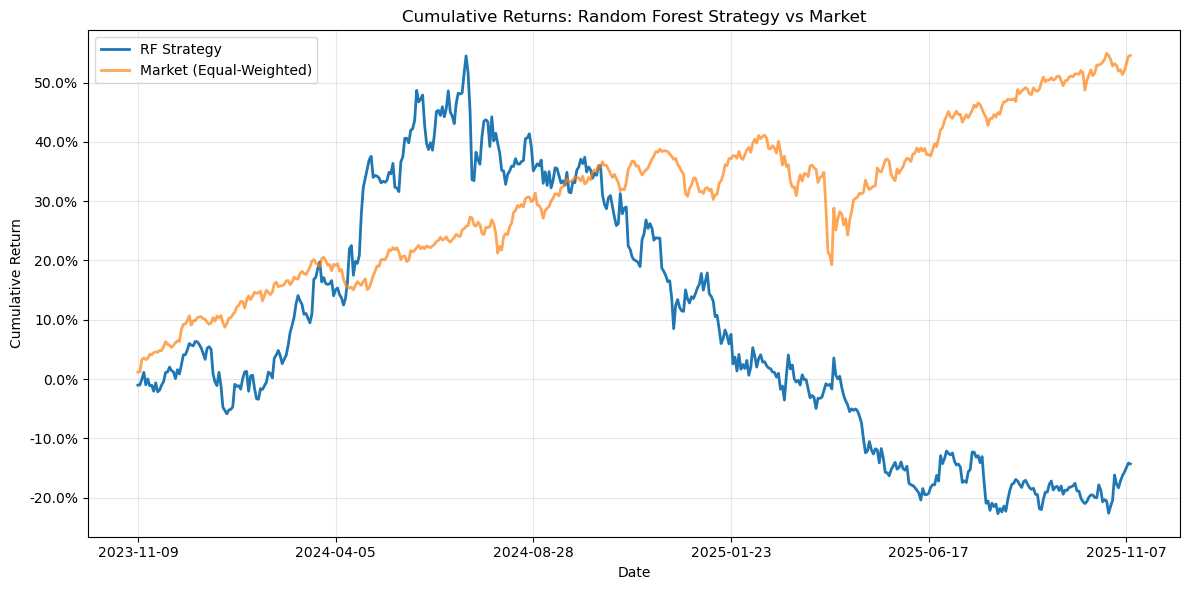

In [80]:
plt.figure(figsize=(12,6))
cumulative_strategy_returns.plot(label='RF Strategy', linewidth=2)
cumulative_market_returns.plot(label='Market (Equal-Weighted)', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns: Random Forest Strategy vs Market')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [73]:
sharpe_strategy = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std()!=0 else np.nan
sharpe_market = market_returns.mean() / market_returns.std() * np.sqrt(252) if market_returns.std()!=0 else np.nan

In [74]:
print(f"Strategy Total Return: {cumulative_strategy_returns.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns.iloc[-1]:.2%}")
print(f"Strategy Sharpe Ratio: {sharpe_strategy:.2f}")
print(f"Market Sharpe Ratio: {sharpe_market:.2f}")

Strategy Total Return: -28.78%
Market Total Return: 54.60%
Strategy Sharpe Ratio: -0.61
Market Sharpe Ratio: 1.71
